# Time Series Project

En la primera etapa nos ocupamos de cargar los datos

# CARGANDO EL DATASET

In [1]:
import pandas as pd # codding
import pandas # for annotations

import warnings

warnings.filterwarnings("ignore")

from paquete_proyecto.iniciando.bases import importar_databases
from paquete_proyecto.herramientas.data_info import data_info

In [2]:
ventas, ventas_sin_duplicados = importar_databases()

La longitud de la serie Nº 1 es de: 127255
La longitud de la serie Nº 2 es de: 108794


In [3]:
display(ventas.sample(3))
data_info(ventas, "ventas")

,IdCliente,NombreCliente,Empleado,Referencia,Descripcion,CodigoFamilia,Familia,Cantidad,Ventas,Localidad,Sede,Area
Fecha,,,,,,,,,,,,
2017-11-10,C830056475,ABACO SAS,43.0,SE-CS-4-0001,REPARACION MENOR DE LLANTA (DESPINCHE ) TACO,106.0,SERVICIOS,1,16807,Puente aranda,Calle 13,35.0
2019-11-12,C17710419,VANEGAS CARLOS,55.0,SE-CS-3-0002,MONTAJE CAMION,106.0,SERVICIOS,4,40336,Puente aranda,Calle 13,35.0
2019-09-20,C3348206,SANTA MARIA URIBE JUAN PEDRO,56.0,SE-CS-11-0002,RECTIFICACION RIN LUJO,106.0,SERVICIOS,2,84034,Usaquen,Santa ana,33.0


info de ventas,columna,type,count,NaN,NaN_pct,unique,unique_pct
0,IdCliente,object,127255,0,0.0 %,24122,18.96 %
1,NombreCliente,object,127255,0,0.0 %,21840,17.16 %
2,Empleado,float64,127255,0,0.0 %,56,0.04 %
3,Referencia,object,127255,0,0.0 %,1854,1.46 %
4,Descripcion,object,127255,0,0.0 %,1814,1.43 %
5,CodigoFamilia,float64,127255,0,0.0 %,5,0.0 %
6,Familia,object,127255,0,0.0 %,5,0.0 %
7,Cantidad,object,127255,0,0.0 %,213,0.17 %
8,Ventas,object,127255,0,0.0 %,14279,11.22 %
9,Localidad,object,127255,0,0.0 %,6,0.0 %


<div>
    <h4>Evaluación de cada columna</h4>
    <ol>
        <li> <b>IdCliente</b>: object - código alfanumérico</li><br />
        <li> <b>NombreCliente</b>: object - string = Nombre, Apellido</li><br />
        <li> <b>>> Empleado</b>: float - cambiar a int</li><br />
        <li> <b>Referencia</b>: object: categoría ordinal</li><br />
        <li> <b>Descripcion</b>: object: categoria cualitativa </li><br />
        <li> <b>>> CodigoFamilia</b>: float64: Cambiar a int</li><br />
        <li> <b>Familia</b>: object: categoria cualitativa</li><br />
        <li> <b>>>Cantidad</b>: object: cambiar a int</li><br />
        <li> <b>>> Ventas</b>: int: cambiar a float</li><br />
        <li> <b>Localidad</b>: object: categoria bussines</li><br />
        <li> <b>>> Area</b>: float: cambiar a int</li><br />
    </ol>
</div>

In [4]:
from paquete_proyecto.iniciando.variables import ajustar_tipos

In [5]:
data, ventas_sin_duplicados = ajustar_tipos(ventas), ajustar_tipos(ventas_sin_duplicados)

# CREANDO LAS REPRESENTACIONES TEMPORALES
Para cada una de las variables, debería haber una representación temporal, en el que cada registro represente una día unicamente

In [6]:
# crear una pivot table. que en el indice tenga fechas, en las columnas tenga localidad, y que los valores sean la cantidad de clientes que tuvo.

pd.pivot_table(data, values="IdCliente", index="Fecha", columns="Localidad", aggfunc="count")

Localidad,Barrios unidos,Bogota,Engativa,Puente aranda,Suba,Usaquen
Fecha,,,,,,
2016-01-09,7.0,16.0,68.0,11.0,19.0,11.0
2016-01-10,6.0,19.0,37.0,4.0,22.0,8.0
2016-01-11,7.0,17.0,100.0,29.0,13.0,5.0
2016-01-12,5.0,14.0,107.0,5.0,17.0,12.0
2016-02-09,3.0,1.0,46.0,33.0,11.0,7.0
...,...,...,...,...,...,...
2020-10-02,5.0,17.0,79.0,11.0,13.0,NaN
2020-10-03,3.0,NaN,41.0,20.0,16.0,8.0
2020-11-01,2.0,2.0,49.0,12.0,14.0,9.0


In [7]:
# crear una pivot table como la anterior, que en los values tenga cantidad de empleados
pd.pivot_table(data, values="Empleado", index="Fecha", columns="Localidad", aggfunc="count")

print ('Al parecer por cada transacción hay un empleado, no hay 2 transacciones realizadas por el mismo empleado en 1 dia')

Al parecer por cada transacción hay un empleado, no hay 2 transacciones realizadas por el mismo empleado en 1 dia


In [8]:
data.Familia.unique()

array(['LLANTA', 'SERVICIOS', 'REENCAUCHE', 'LUBRICANTES', 'FILTROS'],
      dtype=object)

# COMPLETANDO EL DATASET

Primero tenemos que armar cada una de las series temporales

Para poder aplicar Cross-Validation a la serie temporal, es necesario completar con las fechas faltantes con algun valor default en sus variables. De esta forma podremos garantizar que nuestro folds representan el mismo timedelta.

In [9]:
from paquete_proyecto.prepocesamiento.inicial import complete_dates

In [10]:
data = complete_dates(ventas)


# ARMANDO MUESTREOS TEMPORALES

Vamos a hacer cross validation con scikit learn sobre un DataFrame:

Si empezamos por 2016-01-09 y terminamos en 2020-12-02, tenemos 1790 días.

Como querémos cortes de igual tamaño, y sin gap al max_train_size y al test_size le damos el mismo valor.

Como queremos cortes bimensuales ingresamos los parámetros con valor 60.

Para n_splits hacemos 1790 / 60 = 29.8 por eso elegimos 29 folds.

In [11]:
from paquete_proyecto.prepocesamiento.inicial import timeseries_cv

In [12]:
lista_mensual = timeseries_cv(data, 59, 30, 30)

## visualizar población lista_mensual

[Text(0.5, 1.0, 'Cantidad de ventas cada 15 días')]

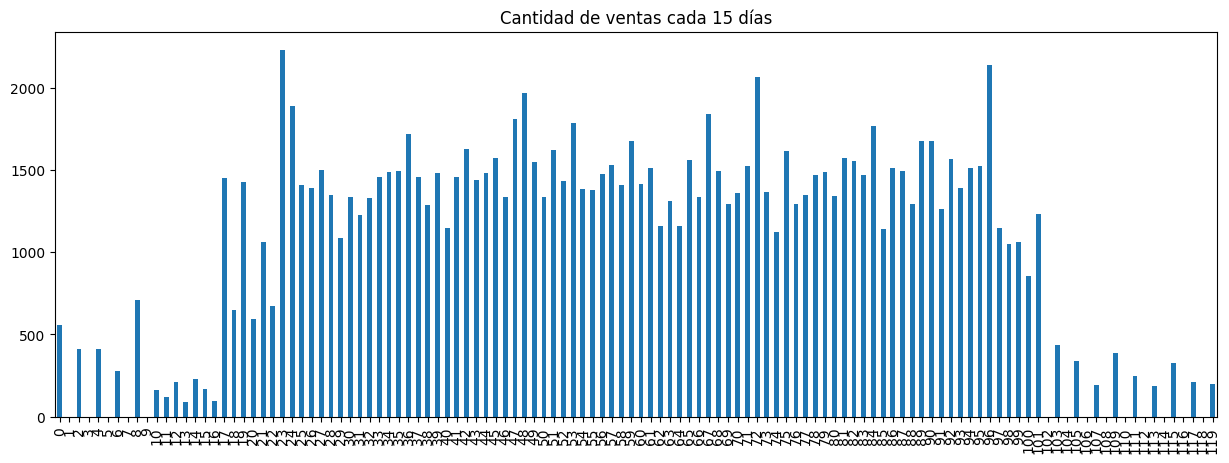

In [35]:
longitud = []
for elemento in lista_mensual:
    longitud.append(len(elemento.dropna()))

pd.Series(longitud).plot.bar(figsize=(15,5)).set(title='Cantidad de ventas cada 30 días')

In [15]:
#AttributeError: AxesSubplot.set() got an unexpected keyword argument 'style'
import matplotlib.pyplot as plt

### help (plt.axes.AxesSubplot.set())

AttributeError: 'function' object has no attribute 'AxesSubplot'